# Аналитика в электронной коммерции (продажа билетов)

Поставлена задача помочь отделу аналитики Яндекс.Афиши. 
Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

### Навигация

1. [Загрузка данных и подготовка их к анализу](#start)
2. [Построение отчетов и расчет метрик](#discover)
3. [Анализ продаж](#buy)
4. [Анализ маркетинга](#marketing)
5. [Вывод: рекомендации маркетологам, куда и сколько им стоит вкладывать денег?](#Conclusion)


### Шаг 1. <a id="start"></a> Загрузка данных и подготовка их к анализу

In [138]:
# импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

pd.options.mode.chained_assignment = None

In [139]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.info()
                    # преобразуем тип данных у End Ts и Start Ts к типу datetime
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format='%Y-%m-%d %H:%M:%S')
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format='%Y-%m-%d %H:%M:%S')
visits.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [140]:
# ДОПОЛНИТЕЛЬНЫЙ БЛОК - срез дат, чтобы при изучении не рассматривались сессии, завершившиеся уже в июня 2018 года.
visits = visits[~visits['Uid'].isna() & (visits['End Ts'] < '2018-06-01 00:00:00')]
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [141]:
costs = pd.read_csv('/datasets/costs.csv')
costs.info()
                    # преобразуем тип данных в столбце dt к типу datetime
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
costs.columns = ['Source Id','dt','costs']
costs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,Source Id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [142]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.info()
                        # преобразуем тип данных в столбце Buy Ts к типу datetime
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format='%Y-%m-%d %H:%M:%S')

# ДОПОЛНИТЕЛЬНЫЙ БЛОК - срез дат, чтобы при изучении не рассматривались покупки, совершенные уже 1 июня 2018 года.
orders = orders[~orders['Uid'].isna() & (orders['Buy Ts'] < '2018-06-01 00:00:00')]

orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


#### Вывод
Полученные для анализа файлы содержали следующую информацию:
1. Таблица visits (лог сервера с информацией о посещениях сайта):


- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь




2. Таблица orders (информация о заказах):


- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа


3. Таблица costs (информация о затратах на маркетинг):


- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

В целях предобработки данных даты с временем были преобразованы в типу datetime. Сделан срез дат при предобработке файла с визитами и покупками, чтобы при изучении не рассматривались сессии и покупки, завершившиеся 1 июня 2018 года.

### Шаг 2. <a id="discover"></a> Построение отчетов и расчет метрик

#### Анализ продукта
###### Сколько людей пользуются в день, неделю, месяц?

In [143]:
visits['day'] = visits['Start Ts'].dt.dayofyear
visits['week'] = visits['Start Ts'].dt.week
visits['month'] = visits['Start Ts'].dt.month

dau_total = int(visits.groupby('day').agg({'Uid': 'nunique'}).mean())
wau_total = int(visits.groupby('week').agg({'Uid': 'nunique'}).mean())
mau_total = int(visits.groupby('month').agg({'Uid': 'nunique'}).mean())

print('В день среднее число пользователей - {}'.format(dau_total))
print('В неделю среднее число пользователей - {}'.format(wau_total))
print('В среднем в месяц число пользователей - {}'.format(mau_total))

В день среднее число пользователей - 907
В неделю среднее число пользователей - 5825
В среднем в месяц число пользователей - 23227


###### Сколько сессий в день?

In [144]:
sessio_per_day = visits.groupby('day').agg({'Uid': 'count'})
sessio_per_day['Uid'].describe() 
# отличие между медианой и средним незначительна (значит выбросы не оказывают существенного влияния), 
# можно ориентироваться на среднее значение

print('В среднем число сессия в день - {}'.format(int(sessio_per_day.mean())))

В среднем число сессия в день - 987


###### Сколько длится одна сессия?

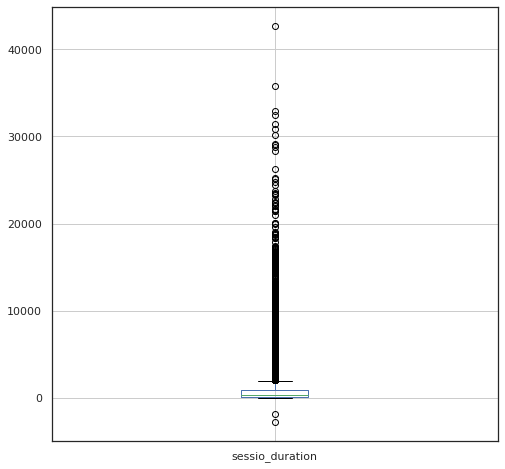

In [145]:
# Новый код, файл с визитами не пересохраняется, а создается новая переменная sessio_visits 
# и уже в ней оставим только те значения, которые входят нормальные значения
# межквартильный размах равен 720. Следовательно, границы значений от 0 до 1560 секунд

visits['sessio_duration'] = (visits['End Ts'] - visits['Start Ts']).astype('timedelta64[s]').astype(int)
(visits
 .sort_values(by='sessio_duration', ascending=False)
 .boxplot('sessio_duration', figsize=(8,8)))

visits['sessio_duration'].describe()

sessio_visits = visits.query('0 < sessio_duration <= 1560') 

In [146]:
sessio_visits = (sessio_visits['sessio_duration'].mean()) / 60
print('В среднем длительность одной сессии составляет {:.2f} минут'.format(sessio_visits))

В среднем длительность одной сессии составляет 7.36 минут


###### Как часто люди возвращаются?

In [147]:
first_sessio_dates = visits.groupby('Uid')['Start Ts'].min() #создаем переменную, в которую сохраним первую сессию пользователя
first_sessio_dates.name = 'first_sessio_datetime' #переименовываем название столбца
visits = visits.join(first_sessio_dates, on='Uid') #объединяем с исходной таблицей
visits

,Device,End Ts,Source Id,Start Ts,Uid,day,week,month,sessio_duration,first_sessio_datetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,354,51,12,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,50,8,2,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,182,26,7,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,140,20,5,1440,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,361,52,12,0,2017-12-27 14:06:00
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,210,30,7,19,2017-07-29 19:07:00
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,25,4,1,19,2018-01-25 17:38:00
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,62,9,3,19,2018-03-03 10:12:00
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,306,44,11,19,2017-11-02 10:12:00


In [148]:
visits['sessio_month'] = visits['Start Ts'].astype('datetime64[M]') #столбец с месяцем посещения сайта
visits['first_sessio_month'] = visits['first_sessio_datetime'].astype('datetime64[M]') #столбец с месяцем первого посещения

visits_table = visits.pivot_table(index='first_sessio_month', #сводная таблица о распределении посещаемости в разрезе когорт
        columns='sessio_month',
        values='Uid',
        aggfunc='nunique')
visits_table
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid,day,week,month,sessio_duration,first_sessio_datetime,sessio_month,first_sessio_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,354,51,12,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,50,8,2,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,182,26,7,0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,140,20,5,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,361,52,12,0,2017-12-27 14:06:00,2017-12-01,2017-12-01
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,246,35,9,60,2017-09-03 21:35:00,2017-09-01,2017-09-01
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,30,5,1,3360,2017-06-29 09:00:00,2018-01-01,2017-06-01
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,309,44,11,60,2017-11-05 15:14:00,2017-11-01,2017-11-01
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,200,29,7,180,2017-07-19 10:41:00,2017-07-01,2017-07-01
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,312,45,11,60,2017-11-08 13:42:00,2017-11-01,2017-11-01


In [149]:
# Расчёт Retention Rate для посещаемости по месяцам

visits['cohort_lifetime'] = visits['sessio_month'] - visits['first_sessio_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype(int)

cohorts = visits.groupby(['first_sessio_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()

inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_sessio_month','Uid']]
inital_users_count = inital_users_count.rename(columns={'Uid':'cohort_users'})

cohorts = cohorts.merge(inital_users_count,on='first_sessio_month')

cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users']
cohorts['first_sessio_month'] = cohorts['first_sessio_month'].dt.strftime('%Y-%m')

retention_pivot = cohorts.pivot_table(index='first_sessio_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10
first_sessio_month,,,,,,,,,,,
2017-06,1.0,NaN,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.084018,0.040652,0.044951
2017-07,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.073744,NaN,0.049239,NaN
2017-08,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.065809,0.027895,0.026029,NaN,NaN
2017-09,1.0,NaN,0.102490,NaN,0.039392,0.065673,0.024186,0.022809,NaN,NaN,NaN
2017-10,1.0,0.078608,0.052239,0.038958,0.058860,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11,1.0,NaN,0.044113,0.065069,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.055802,0.062134,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.089816,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


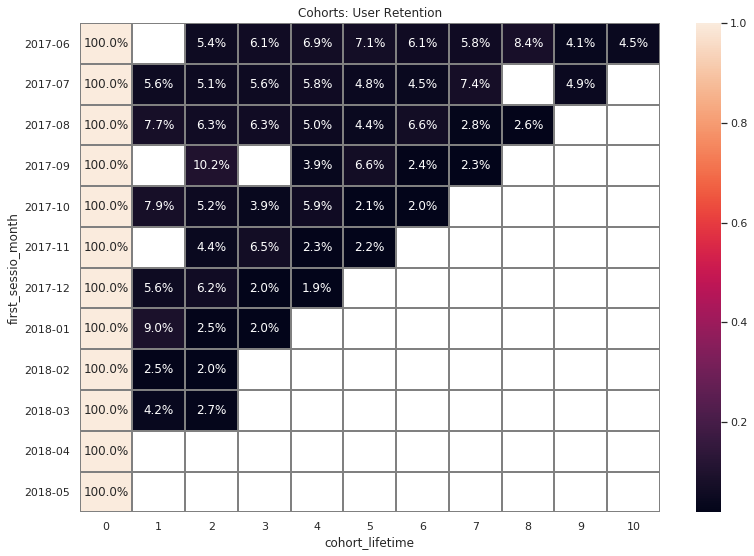

In [150]:
# визуализация получившихся результатов
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

#### Вывод по анализу посещаемости
По результатам расчета метрик выявлено:
- В день среднее число пользователей - 907
- В неделю среднее число пользователей - 5825
- В среднем в месяц число пользователей - 23227

В среднем число сессия в день - 987
В результате изучения показателя Retention Rate по повторным посещениям выявлено, что возвращается в сервис только от 1,9% до 8,4% пользователей. Это низкий показатель. Необходимо повышать вовлеченность посетителей. Возможно стоит делать рассылки, либо привлекать интересными акциями.

#### <a id="buy"></a> Анализ продаж
##### Когда люди начинают покупать?

In [151]:
visits_and_orders = visits.merge(orders, on='Uid', how='inner')

In [152]:
first_buy_dates = visits_and_orders.groupby('Uid')['Buy Ts'].min() 
#создаем переменную, в которую сохраним первую покупку пользователя

first_buy_dates.name = 'first_buy_dates' #переименовываем название столбца
visits_and_orders = visits_and_orders.join(first_buy_dates, on='Uid') #объединяем с исходной таблицей
visits_and_orders

,Device,End Ts,Source Id,Start Ts,Uid,day,week,month,sessio_duration,first_sessio_datetime,sessio_month,first_sessio_month,cohort_lifetime,Buy Ts,Revenue,first_buy_dates
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,140,20,5,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,68,10,3,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,246,35,9,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,246,35,9,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,246,35,9,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761797,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,333,48,11,1260,2017-11-29 20:27:00,2017-11-01,2017-11-01,0,2017-11-29 20:33:00,3.05,2017-11-29 20:33:00
761798,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,113,17,4,480,2018-04-23 21:11:00,2018-04-01,2018-04-01,0,2018-04-23 21:16:00,0.49,2018-04-23 21:16:00
761799,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,212,31,7,1080,2017-07-31 12:13:00,2017-07-01,2017-07-01,0,2017-07-31 12:27:00,2.44,2017-07-31 12:27:00
761800,desktop,2018-05-31 21:04:19,2,2018-05-31 21:04:00,12484396335714047199,151,22,5,19,2018-05-31 21:04:00,2018-05-01,2018-05-01,0,2018-05-31 21:04:00,2.20,2018-05-31 21:04:00


In [153]:
visits_and_orders = visits_and_orders[~visits_and_orders['Revenue'].isna() & 
                                      (visits_and_orders['first_buy_dates'] > visits_and_orders['first_sessio_datetime'])]

# исключаем те значения, когда время покупки раньше чем время посещения сайта
# и находим время, прошедшее с первой покупки
visits_and_orders['time_to_pay'] = visits_and_orders['first_buy_dates'] - visits_and_orders['first_sessio_datetime']

# добавляем столбец с месяцем покупки
visits_and_orders['order_month'] = visits_and_orders['Buy Ts'].astype('datetime64[M]')
visits_and_orders['first_buy_month'] = visits_and_orders['first_buy_dates'].astype('datetime64[M]')

visits_and_orders

,Device,End Ts,Source Id,Start Ts,Uid,day,week,month,sessio_duration,first_sessio_datetime,sessio_month,first_sessio_month,cohort_lifetime,Buy Ts,Revenue,first_buy_dates,time_to_pay,order_month,first_buy_month
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,140,20,5,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,00:20:00,2018-03-01,2018-03-01
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,68,10,3,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,00:20:00,2018-03-01,2018-03-01
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,246,35,9,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00,15:11:00,2017-09-01,2017-09-01
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,246,35,9,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00,15:11:00,2017-10-01,2017-09-01
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,246,35,9,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00,15:11:00,2017-10-01,2017-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761795,desktop,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,338,49,12,480,2017-12-04 12:42:00,2017-12-01,2017-12-01,0,2017-12-04 12:46:00,4.15,2017-12-04 12:46:00,00:04:00,2017-12-01,2017-12-01
761796,desktop,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,324,47,11,660,2017-11-20 23:33:00,2017-11-01,2017-11-01,0,2017-11-20 23:43:00,3.67,2017-11-20 23:43:00,00:10:00,2017-11-01,2017-11-01
761797,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,333,48,11,1260,2017-11-29 20:27:00,2017-11-01,2017-11-01,0,2017-11-29 20:33:00,3.05,2017-11-29 20:33:00,00:06:00,2017-11-01,2017-11-01
761798,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,113,17,4,480,2018-04-23 21:11:00,2018-04-01,2018-04-01,0,2018-04-23 21:16:00,0.49,2018-04-23 21:16:00,00:05:00,2018-04-01,2018-04-01


In [154]:
time_to_first_buy = visits_and_orders.groupby('time_to_pay')['Uid'].count()
time_to_first_buy.sort_values(ascending=False)

time_to_pay
4 days 07:51:00     80565
1 days 23:49:00     62427
0 days 00:17:00     46235
1 days 00:07:00     26731
0 days 00:13:00     25426
                    ...  
36 days 04:29:00        1
36 days 01:41:00        1
36 days 00:26:00        1
35 days 21:39:00        1
22 days 02:27:00        1
Name: Uid, Length: 10560, dtype: int64

##### Сколько раз покупают за период?

In [155]:
orders_count = visits_and_orders.groupby(['first_buy_month','order_month']).agg({'Uid': 'nunique', 'Revenue': 'count'})
orders_count['orders_per_user'] = (orders_count['Revenue'] / orders_count['Uid']).astype('int') 
# число заказов может быть только целочисленным

orders_count
orders_count['orders_per_user'].describe()
# распределение не похоже на нормальное, лучше смотреть моду

orders_count['orders_per_user'].mode() # чаще всего покупали 4 раза (это мода).

0    4
dtype: int64

##### Какой средний чек? 

In [156]:
orders_grouped_by_cohorts = visits_and_orders.groupby(['first_buy_month','order_month']).agg({'Revenue':'mean','Uid':'nunique'})

# распределение среднего чека в зависимости от когорты
orders_grouped_by_cohorts.pivot_table(index='first_buy_month', columns= 'order_month', values='Revenue',aggfunc='mean')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_buy_month,,,,,,,,,,,,
2017-06-01,5.8891,6.388486,4.862942,10.477206,7.128347,7.836328,8.081594,7.919492,6.097613,7.430296,15.761786,10.167685
2017-07-01,NaN,11.664028,12.404542,17.327020,12.150272,7.573365,3.496705,2.961096,8.764952,17.400289,35.280948,6.314145
2017-08-01,NaN,NaN,7.020379,7.792493,6.751591,9.045015,10.275148,8.220924,7.593369,10.458225,6.891591,7.895131
2017-09-01,NaN,NaN,NaN,13.638272,30.996440,13.029476,117.539678,35.931097,29.033154,32.874386,23.857148,13.747318
2017-10-01,NaN,NaN,NaN,NaN,6.457265,12.265999,7.104895,10.216400,5.888078,6.445127,4.926982,3.997276
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.796109,6.950539,7.774461,8.647019,6.125701,4.030100,6.882395
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.247657,4.735144,9.148710,11.343209,8.693969,7.342155
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.747820,4.967811,10.338837,6.783572,2.718705
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.783141,4.571727,4.292789,3.220425


In [157]:
print('Cредняя выручка с одного заказа составляет {:.2f} рублей'.format(visits_and_orders['Revenue'].mean()))

Cредняя выручка с одного заказа составляет 9.59 рублей


##### Сколько денег приносят? (LTV)

In [158]:
cohort_sizes = visits_and_orders.groupby('first_buy_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_buyers']
ltv_cohorts = visits_and_orders.groupby(['first_buy_month','order_month']).agg({'Revenue': 'sum'}).reset_index()
# Строка таблицы ltv_cohorts показывает, какую выручку принесла когорта.
report = pd.merge(cohort_sizes, ltv_cohorts, on='first_buy_month')
report.head(10)

,first_buy_month,n_buyers,order_month,Revenue
0,2017-06-01,1823,2017-06-01,121286.02
1,2017-06-01,1823,2017-07-01,121873.14
2,2017-06-01,1823,2017-08-01,100638.58
3,2017-06-01,1823,2017-09-01,332546.53
4,2017-06-01,1823,2017-10-01,233460.50
5,2017-06-01,1823,2017-11-01,185462.38
6,2017-06-01,1823,2017-12-01,298606.80
7,2017-06-01,1823,2018-01-01,169508.80
8,2017-06-01,1823,2018-02-01,204916.38
9,2017-06-01,1823,2018-03-01,186626.74


In [159]:
margin_rate = 1 # допустимость, что маржинальность равна 100%
    
report['gp'] = report['Revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_buy_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round()
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,67.0,67,55,182,128,102,164,93,112,102,110,50
2017-07-01,55.0,28,86,31,12,14,7,9,16,22,15,
2017-08-01,36.0,33,28,33,53,25,18,39,17,12,,
2017-09-01,66.0,65,24,341,39,52,69,24,12,,,
2017-10-01,22.0,8,3,4,3,2,2,3,,,,
2017-11-01,29.0,22,11,22,8,1,7,,,,,
2017-12-01,18.0,9,18,15,6,5,,,,,,
2018-01-01,19.0,13,17,5,3,,,,,,,
2018-02-01,13.0,7,3,2,,,,,,,,


In [160]:
ltv_20170601 = output.loc['2017-06-01'].sum()

print(f'В среднем каждый покупатель из первой когорты принес по {ltv_20170601} рублей выручки за 12 месяцев «жизни». Это самый максимальный показатель среди всех когорт.') 

В среднем каждый покупатель из первой когорты принес по 1232.0 рублей выручки за 12 месяцев «жизни». Это самый максимальный показатель среди всех когорт.


#### Вывод по анализу продаж

Для ответа на вопрос когда начинают покупать было выявлено, что большинство посетителей покупают через 4 дня 7 часов 51 минуту (80565 пользователей). Немного меньше через 1 день 23 часа 49 минут (62427) и 17 минут (46235).

Построена таблица распределения средней выручки по когорта. Общая средняя выручка с одного заказа составляет примерно 9.59 рублей.

Зачастую (мода выборки) покупают 4 раза за указанный период.

В среднем каждый покупатель из первой когорты принес по 1232.0 рублей выручки за 12 месяцев «жизни». Это самый максимальный показатель среди всех когорт.

#### <a id="marketing"></a> Анализ маркетинга
##### Сколько денег потратили? Всего / на каждый источник / по времени

In [161]:
print('Всего на меркетинговую кампанию потратили {} рублей'.format(costs['costs'].sum()))

Всего на меркетинговую кампанию потратили 329131.62 рублей


In [162]:
# затраты по источникам
costs_source_id = costs.groupby('Source Id')['costs'].sum()
costs_source_id

Source Id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

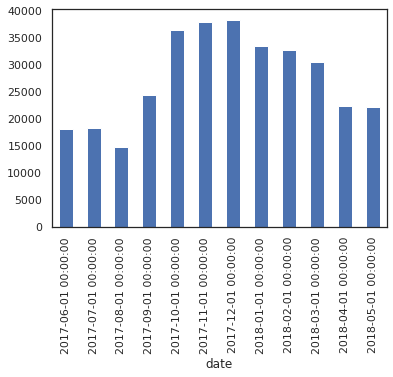

In [163]:
# затраты по месяцам
costs['date'] = costs['dt'].astype('datetime64[M]')
costs_dt = costs.groupby('date')['costs'].sum()
costs_dt
costs_dt.plot(kind='bar')

##### Сколько стоило привлечение одного покупателя из каждого источника?

In [164]:
# определим число покупателей в разрезе рекламного источника, по которому он пришел
visits_source = visits_and_orders.groupby(['Source Id', 'Device']).agg({'Uid' : 'count', 'Revenue' : 'sum'}).reset_index()
visits_source['Revenue'] = visits_source['Revenue'].astype('int')#.round()
visits_source#.info()

,Source Id,Device,Uid,Revenue
0,1,desktop,210575,1938978
1,1,touch,11437,199621
2,2,desktop,204862,2363584
3,2,touch,13521,161941
4,3,desktop,38651,255119
5,3,touch,4570,23098
6,4,desktop,45497,374493
7,4,touch,10019,77747
8,5,desktop,115871,973249
9,5,touch,3756,24210


In [165]:
source = pd.concat([visits_source, costs_source_id], axis=1)
source['costs_per_sourse'] = source['costs'] / source['Uid']

In [166]:
# стоимость привлечения одного покупателя в зависимости от рекламного канала и устройства
(source
 .groupby(['Source Id', 'Device'])['costs_per_sourse']
 .sum())

Source Id  Device 
1          desktop       0.000000
           touch         1.821568
2          desktop       0.208951
           touch        10.452010
3          desktop       1.580130
           touch        11.325405
4          desktop       0.000000
           touch         0.000000
5          desktop       0.000000
           touch         1.468980
7          desktop    5822.490000
9          desktop       0.000000
           touch         0.000000
10         desktop       0.000000
           touch         0.000000
Name: costs_per_sourse, dtype: float64

##### На сколько окупились расходы? (ROI)

In [167]:
source['roi, %'] = (source['Revenue'] - source['costs']) / source['costs'] * 100
source.pivot_table(index=['Device', 'Source Id'], values='roi, %')

roi, %
Device  Source Id             
desktop 2          5421.613305
        3           317.723861
        7           -99.982825
touch   1           858.183713
        2            14.590385
        3           -55.372306
        5           338.786477

##### Построение графиков

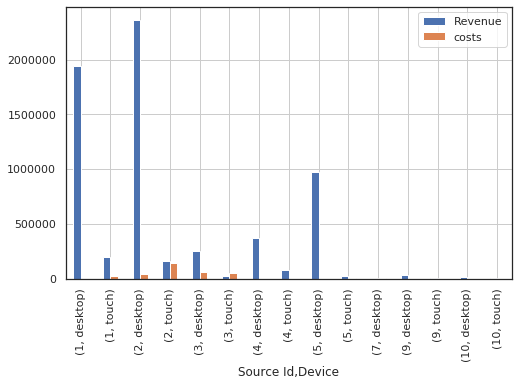

In [168]:
(source.groupby(['Source Id', 'Device'])['Revenue', 'costs']
 .sum()
 .plot(kind='bar', figsize=(8,5), grid=True))

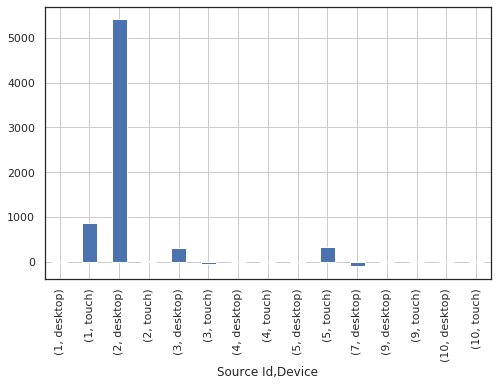

In [169]:
(source.groupby(['Source Id', 'Device'])['roi, %']
 .sum()
 .plot(kind='bar', figsize=(8,5), grid=True))

##### Распределение среднего чека по месяцам покупок в разрезе используемых устройств

In [170]:
(visits_and_orders
    .pivot_table(index='Device', columns='order_month', values='Revenue', aggfunc='mean'))

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
Device,,,,,,,,,,,,
desktop,5.731870,7.981302,6.291955,11.921554,8.960843,7.704871,16.183677,7.914680,7.579825,9.718087,10.607648,6.255290
touch,8.175766,7.951678,5.771794,11.426916,12.538026,8.845524,5.995383,5.561503,6.746083,17.661013,22.711540,8.427942


In [171]:
visits_and_orders.groupby('Device')['Revenue'].mean() # средний чек с портативных  устройств выше

Device
desktop     9.499077
touch      10.807668
Name: Revenue, dtype: float64

##### Расчёт Retention Rate для покупок в зависимости от устройства

In [172]:
# Расчёт Retention Rate для покупок в зависимости от устройства

visits_and_orders['cohort_lifetime_order'] = visits_and_orders['order_month'] - visits_and_orders['first_buy_month']
visits_and_orders['cohort_lifetime_order'] = visits_and_orders['cohort_lifetime_order'] / np.timedelta64(1,'M')
visits_and_orders['cohort_lifetime_order'] = visits_and_orders['cohort_lifetime_order'].astype(int)

cohorts_orders = visits_and_orders.groupby(['Device','cohort_lifetime_order']).agg({'Uid':'nunique'}).reset_index()

inital_users_count_orders = cohorts_orders[cohorts_orders['cohort_lifetime_order'] == 0][['Device','Uid']]
inital_users_count_orders = inital_users_count_orders.rename(columns={'Uid':'cohort_users'})

cohorts_orders = cohorts_orders.merge(inital_users_count_orders, on='Device')

cohorts_orders['retention'] = cohorts_orders['Uid']/cohorts_orders['cohort_users']

retention_pivot_orders = cohorts_orders.pivot_table(index='Device',columns='cohort_lifetime_order',values='retention',aggfunc='sum')
retention_pivot_orders

cohort_lifetime_order,0,1,2,3,4,5,6,7,8,9,10
Device,,,,,,,,,,,
desktop,1.0,0.022919,0.026029,0.015932,0.015058,0.011425,0.008280,0.005590,0.003459,0.002725,0.001572
touch,1.0,0.027468,0.029747,0.017272,0.016553,0.012115,0.009716,0.006837,0.004078,0.003359,0.001559


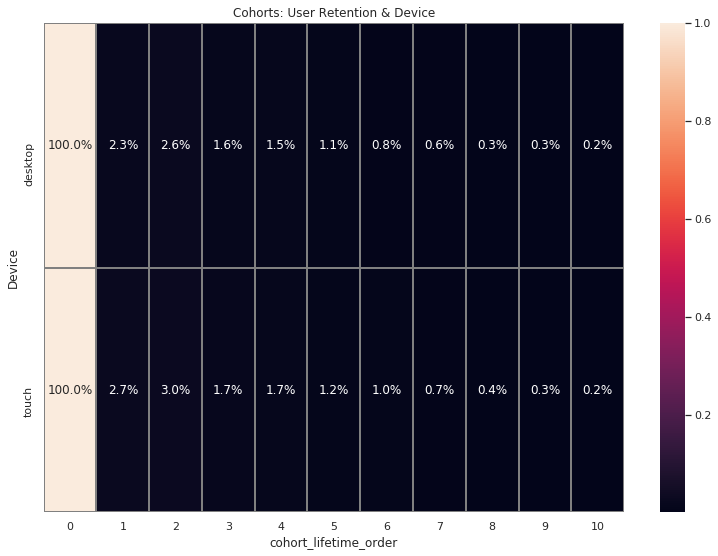

In [173]:
# визуализация получившихся результатов - у портативных устройств снижение активности покупателей происходит медленнее
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention & Device')
sns.heatmap(retention_pivot_orders, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

#### Вывод по анализу маркетинга
Всего на маркетинговую кампанию потратили 329131.62 руб.

Больше всего бюджета выделено на третий (141321.63 руб.) и четвертый (61073.60 руб.) маркетинговый канал.

Затраты с октября 2017 по март 2018 примерно равные - скорее всего активная рекламная кампания была направлена на привлечение клиентов к различным праздникам в этот период.

С точки зрения окупаемости для настольного компьютера лучший рекламный канал - №2. Также хорошие (но в разы хуже) показатели у 3 канала. Но ни в коем случае не стоит использовать 7 канал. 

Для портативных устройств самый лучший выбор каналы 1 и 5.У них самый высокие показатели окупаемости затрат, а 3 имеет наихудший показатель.

По результатам изучения распределение среднего чека по месяцам покупок в разрезе используемых устройств было обнаружено, что средний чек с портативных устройств выше (10,8 против 9,49 с настольных компьютеров).

При расчете Retention Rate для покупок в зависимости от устройства также обнаружено, что у портативных устройств снижение активности покупателей происходит медленнее.

### Шаг 3. <a id="Conclusion"></a> Вывод: рекомендации маркетологам, куда и сколько им стоит вкладывать денег?

По результатам изучения полученных для анализа файлов была получена следующая информация.

- В день среднее число пользователей - 907
- В неделю среднее число пользователей - 5825
- В среднем в месяц число пользователей - 23228
- В среднем число сессия в день - 987
- В результате изучения показателя Retention Rate по повторным посещениям выявлено, что возвращается в сервис только 1,9% - 8,4% пользователей. Это низкий показатель. Необходимо повышать вовлеченность посетителей. Возможно стоит делать рассылки, либо привлекать интересными акциями.
- Для ответа на вопрос, когда начинают покупать было выявлено, что большинство посетителей покупают через 4 дня 7 часов 51 минуту (80565 пользователей). Немного меньше через 1 день 23 часа 49 минут (62427) и 17 минут (46235).
- Построена таблица распределения средней выручки по когорта. Средняя выручка с одного заказа среди всех когорт составляет примерно 9.59 рублей.
- Зачастую покупают 4 раза за указанный период (это мода имеющейся выборки). 
- В среднем каждый покупатель из первой когорты принес по 1232.0 рублей выручки за 12 месяцев «жизни». Это самый максимальный показатель среди всех когорт.
- Всего на маркетинговую кампанию за период потратили 329131.62 руб.
- Больше всего бюджета выделено на третий (141321.63 руб.) и четвертый (61073.60 руб.) маркетинговый канал.
- Затраты с октября 2017 по март 2018 примерно равные - скорее всего активная рекламная кампания была направлена на привлечение клиентов к различным праздникам в этот период.
- С точки зрения окупаемости для настольного компьютера лучший рекламный канал - №2. Также хорошие (но в разы хуже) показатели у 3 канала. Но ни в коем случае не стоит использовать 7 канал. 
- Для портативных устройств самый лучший выбор каналы 1 и 5.У них самый высокие показатели окупаемости затрат, а 3 имеет наихудший показатель.
- По результатам изучения распределение среднего чека по месяцам покупок в разрезе используемых устройств было обнаружено, что средний чек с портативных устройств выше (10,8 против 9,49 с настольных компьютеров).
- При расчете Retention Rate для покупок в зависимости от устройства также обнаружено, что у портативных устройств снижение активности покупателей происходит медленнее.


Таким образом, с учетом получившихся результатов исследования, можно предположить, что целесообразнее вкладывать в рекламные каналы 1 и 5 для портативных устройств, а для настольного компьютера лучший рекламный канал - №2. Такой подход должен принести максимальную отдачу при минимальных инвестициях.